In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchrl
import matplotlib.pyplot as plt
from tensordict import TensorDict
from flipper_training.environment.torchrl_env import TorchRLEnv
from flipper_training.configs import *
from flipper_training.rl_objectives import *
from flipper_training.utils.heightmap_generators import *

In [3]:
num_robots = 1

In [4]:
from flipper_training.utils.environment import make_x_y_grids, generate_heightmaps

In [5]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
heighmap_gen = MultiGaussianHeightmapGenerator(
    min_gaussians=400,
    max_gaussians=600,
    min_height_fraction=0.03,
    max_height_fraction=0.12,
    min_std_fraction=0.03,
    max_std_fraction=0.08,
    min_sigma_ratio=0.6)
x_grid, y_grid = make_x_y_grids(max_coord, grid_res, num_robots)
z_grid, suit_mask = generate_heightmaps(x_grid, y_grid, heighmap_gen)

In [6]:
from flipper_training.vis.static_vis import plot_heightmap_3d

plot_heightmap_3d(x_grid[0], y_grid[0], z_grid[0])

In [7]:
device = "cpu"

In [8]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv")
world_config = WorldConfig(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000, suitable_mask=suit_mask)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.robot_cache/marv_0.080_192.pt
Robot has 1023 points


In [9]:
from flipper_training.environment.torchrl_env import TorchRLEnvConfig

env_config = TorchRLEnvConfig()

In [10]:
torch_env = TorchRLEnv(env_config, world_config, physics_config, robot_model, device, batch_size=[num_robots])

In [11]:
torchrl.envs.utils.check_env_specs(torch_env)

2025-01-06 10:52:05,516 [torchrl][INFO] check_env_specs succeeded!


In [12]:
# Controls
speed = 1.0  # m/s forward
omega = 0.5  # rad/s yaw
flipper_controls = torch.zeros(robot_model.num_joints)
control_vec = torch.cat([torch.tensor([speed, omega]), flipper_controls]).unsqueeze(0).repeat(num_robots, 1)

In [13]:
control_vec.shape

torch.Size([1, 6])

In [14]:
control_td = TensorDict({"action": control_vec}, batch_size=num_robots)
control_td.shape

torch.Size([1])

In [15]:
torch_env.reset()

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 6]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        goal_vec: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        omega: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        perception: Tensor(shape=torch.Size([1, 1, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
        rotation: Tensor(shape=torch.Size([1, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        thetas: Tensor(shape=torch.Size([1, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        velocity: Tensor(shape=torch.Size([1, 3]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared

In [16]:
for i in range(100):
    out = torch_env.step(control_td)

In [17]:
torch_env.visualize_curr_state()

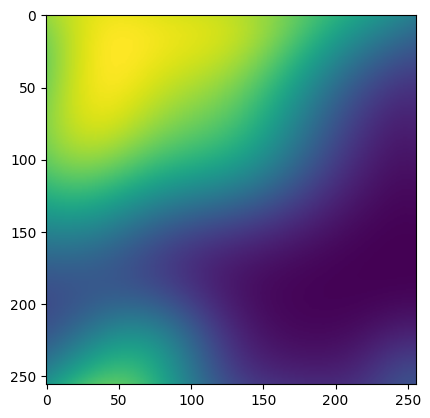

In [18]:
percep = out["next"]["perception"][0,0].cpu().numpy()
plt.imshow(percep)